# MP1: LPC

In this lab, you'll use linear predictive coding (LPC) to analyze and then resynthesize a speech sound.

In order to make sure everything works, you might want to go to the command line, and run

    pip install -r requirements.txt
    
This will install the modules that are used on the autograder, including soundfile, numpy, h5py, and the gradescope utilities.

---------------------------------------------------------------------
## Part 1: Plotting and understanding the spectrogram

First, let's load a speech waveform.  This is an extract from Nicholas James Bridgewater's reading of the Universal Declaration of Human Rights (https://librivox.org/universal-declaration-of-human-rights-volume-03-by-united-nations/).

LPC-10 synthesis was designed for an 8kHz sampling rate, so this file has been resampled to an 8kHz sampling rate.

In [1]:
import soundfile as sf
speech, samplerate = sf.read('humanrights.wav')
import numpy as  np
time_axis = np.arange(len(speech))/samplerate
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.plot(time_axis,speech)
plt.xlabel('Time (seconds)')
plt.title('Speech sample')

Text(0.5, 1.0, 'Speech sample')

Let's zoom in on part of it.

Text(0.5, 1.0, 'Speech sample')

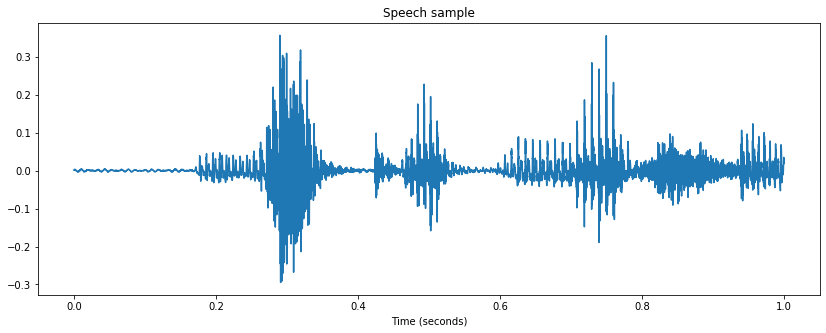

In [2]:
plt.figure(figsize=(14, 5))
plt.plot(time_axis[:samplerate],speech[:samplerate])
plt.xlabel('Time (seconds)')
plt.title('Speech sample')

Let's also look at a spectrogram of the first 1.5 seconds or so, using a window length that's much shorter than one pitch period, so you can see the vertical striations corresponding to glottal closure  instants.  For this we'll use `librosa`.  Note: `librosa` is not available on the autograder, so don't get too dependent on it.

(1025, 751)


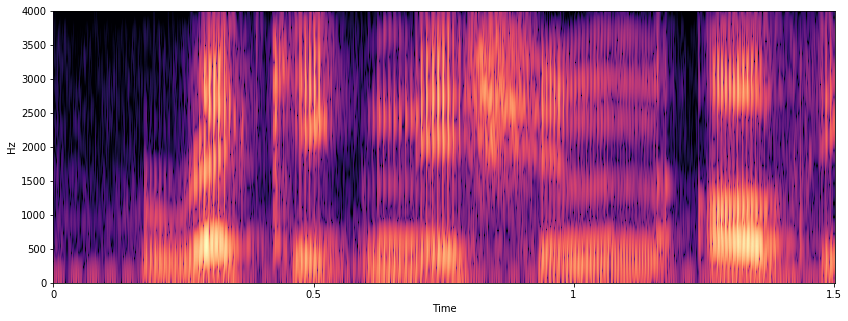

In [3]:
import librosa, librosa.display
S = librosa.stft(speech[:int(1.5*samplerate)], hop_length=int(0.002*samplerate), win_length=int(0.005*samplerate))
Sdb = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Sdb, sr=samplerate, hop_length=int(0.002*samplerate), x_axis='time', y_axis='hz')
print(Sdb.shape)

Just to  make sure we know what's going  on here, let's listen to only the same part of the utterance.

In [4]:
import IPython.display as ipd
ipd.Audio(speech[:int(1.5*samplerate)], rate=samplerate)

Notice how the vowels show up as strongly voiced regions (with vertical striations once per glottal pulse).  The /sh/ in the middle shows up as a loud fricative burst at around 0.8 seconds.  The /k/ , /g/, and the pause between words show up as silences at 0.4, 0.6, and 1.25 seconds, respectively.

------------------------------------------------------------
## Part 2: Chop it into frames

At this point, we'll load the file `submitted.py`.

The file `submitted.py` is the only part of your work that the autograder will see. The only purpose of this notebook is to help you debug `submitted.py`.  Once you have revised `submitted.py` enough to make this notebook work, then you should go to the command line, and type `python run_tests.py`.  Once that command returns without errors, then  you can go ahead and submit your file `submitted.py` to the autograder.  You can submit to the autograder as often as you want, but it will save you trouble if you debug as much as you can on your local machine, before you submit to the autograder.

We will use `importlib` in order to reload your `submitted.py` over and over again.  That way, every time you make a modification in `submitted.py`, you can just re-run  the corresponding block of this notebook, and it will reload `submitted.py` with your modified code.  

Since the file is called `submitted.py`, python considers it to contain a module called `submitted`.  As shown, you can read the module's docstring by printing `submitted.__doc__`.  You can also type `help(submitted)` to get a lot of information about the module, including its docstring, a list of all the functions it defines, and all of their docstrings.  For  more about docstrings, see, for example, https://www.python.org/dev/peps/pep-0257/.

In [5]:
import submitted
import importlib
importlib.reload(submitted)
print(submitted.__doc__)


This is the module you'll submit to the autograder.

There are several function definitions, here, that raise RuntimeErrors.  You should replace
each "raise RuntimeError" line with a line that performs the function specified in the
function's docstring.



Now it's time for you to open `submitted.py`, and start editing it.  You can open it in another Jupyter window by choosing "Open from Path" from the "File" menu, and then typing `submitted.py`.  

Once you have it open, try editing the function `make_frames` so that its functionality matches its docstring.  Here is what it's docstring says:

In [6]:
help(submitted.make_frames)

Help on function make_frames in module submitted:

make_frames(signal, hop_length, win_length)
    frames = make_frames(signal, hop_length, win_length)
    
    signal (num_samps) - the speech signal
    hop_length (scalar) - the hop length, in samples
    win_length (scalar) - the window length, in samples
    frames (num_frames, win_length) - array with one frame per row
    
    num_frames should be enough so that each sample from the signal occurs in at least one frame.
    The last frame may be zero-padded.



If this is working, then dividing the speech signal into 30ms frames (661 samples), with a 15ms hop (330 samples), should yield 1191 frames.

In [7]:
importlib.reload(submitted)
hop_length = int(0.015*samplerate)
win_length = int(0.03*samplerate)
frames = submitted.make_frames(speech, hop_length=hop_length, win_length=win_length)
print('The number of frames, and win_length, are',frames.shape)
print('The hop_length is',hop_length)

The number of frames, and win_length, are (1188, 240)
The hop_length is 120


-------------------------------------
## Part 3: Calculating autocorrelation of each frame

Now write the function ``submitted.correlate``, to satisfy its docstring:

In [8]:
importlib.reload(submitted)
help(submitted.correlate)

Help on function correlate in module submitted:

correlate(frames)
    autocor = correlate(frames)
    
    frames (num_frames, win_length) - array with one frame per row
    autocor (num_frames, 2*win_length-1) - each row is the autocorrelation of one frame



The autocorrelation of frame $x[n]$ is given by 

$$r_{xx}[m] = \sum_n x[n] x[n+m]$$

You can compute this efficiently using https://numpy.org/doc/stable/reference/generated/numpy.correlate.html, but be sure to specify mode='full'.

Notice that the autocorrelation coefficient $R[0]$ is right at the center of each row (at ``autocor[:,win_length-1]``), and the autocorrelation is symmetric.  So for example, ``autocor[0,win_length-3:win_length+2]`` should equal

    [0.00219293 0.00223083 0.00225532 0.00223083 0.00219293]

In [9]:
importlib.reload(submitted)
autocor = submitted.correlate(frames)
print(autocor[0,win_length-3:win_length+2])

[0.000736   0.00078295 0.00081344 0.00078295 0.000736  ]


-------------------------------------------------------------
## Part 4: Make matrices

Now that you've computed the autocorrelation of each frame, you need to re-arrange it into matrices, so that you can find the LPC coefficients.

In [10]:
importlib.reload(submitted)
help(submitted.make_matrices)

Help on function make_matrices in module submitted:

make_matrices(autocor, p)
    R, gamma = make_matrices(autocor, p)
    
    autocor (num_frames, 2*win_length-1) - each row is symmetric autocorrelation of one frame
    p (scalar) - the desired size of the autocorrelation matrices
    R (num_frames, p, p) - p-by-p Toeplitz autocor matrix of each frame, with R[0] on main diagonal
    gamma (num_frames, p) - length-p autocor vector of each frame, R[1] through R[p]



Remember how you these matrices are  defined:

$$R = \left[\begin{array}{cccc} R[0] & R[1] & \cdots & R[p-1]\\ R[1] & R[0] & \cdots & R[p-2] \\ \vdots & \vdots & \ddots & \vdots \\ R[p-1] & R[p-2] & \cdots & R[0]\end{array}\right],~~~
\gamma = \left[\begin{array}{c}R[1]\\R[2]\\\vdots\\R[p]\end{array}\right]$$

The only thing you have to be careful about is that, in the $t^{\textrm{th}}$ frame, $R[0]$ is at the center of ``autocor[t,:]``.  So you have to figure out where the center is, and align things accordingly.  If you get  everything working, then with $p=10$, ``autocor[0,:6,:6]`` should look like this: 

    In frame 0, R is 
    [[0.00225532 0.00223083 0.00219293 0.00215052 0.00210214 0.00205608]
     [0.00223083 0.00225532 0.00223083 0.00219293 0.00215052 0.00210214]
     [0.00219293 0.00223083 0.00225532 0.00223083 0.00219293 0.00215052]
     [0.00215052 0.00219293 0.00223083 0.00225532 0.00223083 0.00219293]
     [0.00210214 0.00215052 0.00219293 0.00223083 0.00225532 0.00223083]
     [0.00205608 0.00210214 0.00215052 0.00219293 0.00223083 0.00225532]]

    and gamma is
    [0.00223083 0.00219293 0.00215052 0.00210214 0.00205608 0.00201097]

In [11]:
importlib.reload(submitted)
R, gamma = submitted.make_matrices(autocor, 10)
print('In frame 0, R is ')
print(R[0,:6,:6])
print('\nand gamma is')
print(gamma[0,:6])

In frame 0, R is 
[[0.00081344 0.00078295 0.000736   0.00069581 0.00066528 0.00063886]
 [0.00078295 0.00081344 0.00078295 0.000736   0.00069581 0.00066528]
 [0.000736   0.00078295 0.00081344 0.00078295 0.000736   0.00069581]
 [0.00069581 0.000736   0.00078295 0.00081344 0.00078295 0.000736  ]
 [0.00066528 0.00069581 0.000736   0.00078295 0.00081344 0.00078295]
 [0.00063886 0.00066528 0.00069581 0.000736   0.00078295 0.00081344]]

and gamma is
[0.00078295 0.000736   0.00069581 0.00066528 0.00063886 0.00060859]


-----------------------------------------------------------
## Part 5: Calculating the LPC coefficients

Now you should calculate the LPC coefficients in each frame!

In [12]:
importlib.reload(submitted)
help(submitted.lpc)

Help on function lpc in module submitted:

lpc(R, gamma)
    a = lpc(R, gamma)
    Calculate the LPC coefficients in each frame
    
    R (num_frames, p, p) - p-by-p Toeplitz autocor matrix of each frame, with R[0] on main diagonal
    gamma (num_frames, p) - length-p autocor vector of each frame, R[1] through R[p]
    a (num_frames,p) - LPC predictor coefficients in each frame



Remember that the normal equations result in the following easy form:

$$a = R^{-1}\gamma$$

In [13]:
importlib.reload(submitted)
a = submitted.lpc(R, gamma)
print(a[0,:6])

[ 1.30340043 -0.5302854   0.18194818 -0.0657513   0.21331657 -0.27316226]


Here's a neat trick we can use, in order to see if the LPC coefficients we've calculated are reasonable.  Remember that the LPC synthesis filter has the following frequency  response:

$$H(\omega) = \frac{G}{1-\sum_{k=1}^p a_k e^{-jk\omega}}$$

If  we calculate $H(\omega)$ explicitly, for every frame, then we can show it as if it were a spectrogram.  It should look similar to the spectrogram of the original speech signal.  It won't have the right amplitude (because we don't know $G$ yet), but it should have the right general shape.

Remember that we're using a 15ms ``hop_length``, so, to match the 1.5 seconds that we plotted earlier, we'll just  do this for the first 100 frames.

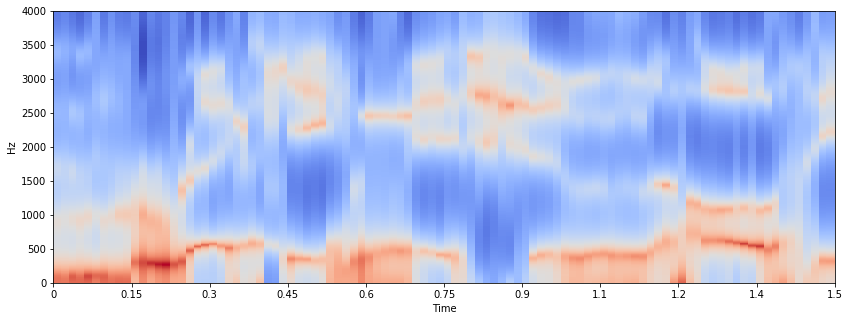

In [14]:
omega = np.arange(1025)*np.pi/1024
inverse_lpc_filter = np.ones((1025, 100), dtype=complex)
for framenum in range(100):
    for k in range(1,11):
        inverse_lpc_filter[:,framenum] -= a[framenum,k-1]*np.exp(-1j*k*omega)
H = 1/inverse_lpc_filter
Hdb = librosa.amplitude_to_db(abs(H))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Hdb, sr=samplerate, hop_length=hop_length, x_axis='time', y_axis='hz')

-----------------------------------------------------------------------------
## Part 6: Calculating the pitch period

In order to synthesize speech, we need to calculate the pitch period in each frame.  In frames that are not voiced, we will signal that by setting ``framepitch`` to zero.

In [15]:
importlib.reload(submitted)
help(submitted.framepitch)

Help on function framepitch in module submitted:

framepitch(autocor, Fs)
    framepitch = framepitch(autocor, samplerate)
    
    autocor (num_frames, 2*win_length-1) - autocorrelation of each frame
    Fs (scalar) - sampling frequency
    framepitch (num_frames) - estimated pitch period, in samples, for each frame, or 0 if unvoiced
    
    framepitch[t] = 0 if the t'th frame is unvoiced
    framepitch[t] = pitch period, in samples, if the t'th frame is voiced.
    Pitch period should maximize R[framepitch]/R[0], in the range 4ms <= framepitch < 13ms.
    Call the frame voiced if and only if R[framepitch]/R[0] >= 0.3, else unvoiced.



Let's see how this will work.  If you look at the spectrogram above, you can see that there is a vowel at about $t=0.3$ seconds, i.e., frame number 20.  There  is a loud unvoiced fricative just before $t=0.9$s, i.e., frame numbers just before 60.  Let's plot those autocorrelations, to compare them. In order to make the comparison easier, we'll normalize each of the two autocorrelations by their $R[0]$ values:

$$C[m] = \frac{R[m]}{R[0]}$$

Text(0.5, 1.0, 'Normalized autocorrelation of an unvoiced frame')

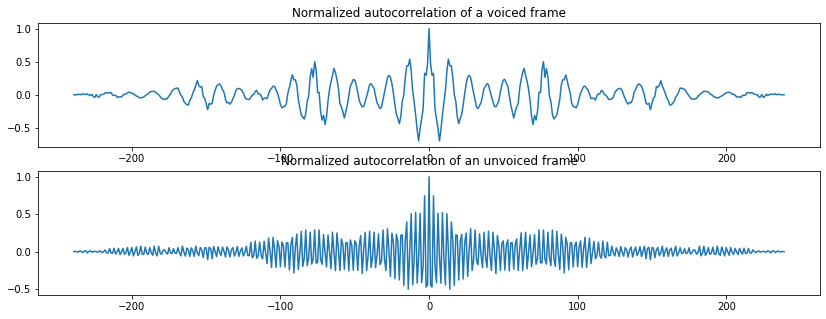

In [16]:
importlib.reload(submitted)
plt.figure(figsize=(14, 5))
plt.subplot(2,1,1)
plt.plot(np.arange(-win_length+1,win_length),autocor[20,:]/autocor[20,win_length-1])
plt.title('Normalized autocorrelation of a voiced frame')
plt.subplot(2,1,2)
plt.plot(np.arange(-win_length+1,win_length),autocor[58,:]/autocor[58,win_length-1])
plt.title('Normalized autocorrelation of an unvoiced frame')

You can see that the voiced frame has a  strong peak at about 80 samples (about $80/8000=10ms$), which seems likely to be the pitch period.  The unvoiced frame has a lot of energy at very high frequencies, but for periods higher than about 20 samples ($20/8000\approx 2.5ms$), the energy all has a normalized autocorrelation of $|C[m]|<0.3$ or so.  So we'll use the following strategy:

* If there is any period in the range $4\textrm{ms}\le T_0< 13\textrm{ms}$ for which $|C[T_0F_s]|\ge 0.3$, then choose the largest such peak, and call it the pitch period.
* If there is no such pitch period, then set ``framepitch[framenum]=0`` to denote an unvoiced frame.

Here is what the result looks like, for the first 100 frames.  You will notice that the voiced/unvoiced (V/UV) decision is actually not very good.  We would do better if we used more features for the V/UV decision, but this will be good enough for the purposes of this MP.

67.0


Text(0.5, 1.0, 'Frame-wise pitch period for the first 100 frames')

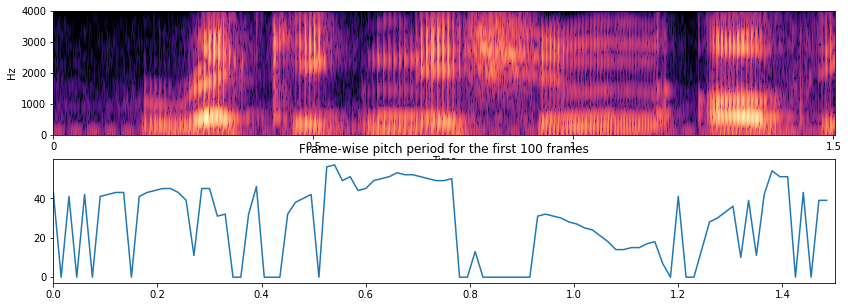

In [65]:
importlib.reload(submitted)
framepitch = submitted.framepitch(autocor, samplerate)
plt.figure(figsize=(14, 5))
plt.subplot(2,1,1)
librosa.display.specshow(Sdb, sr=samplerate, hop_length=int(0.002*samplerate), x_axis='time', y_axis='hz')
plt.subplot(2,1,2)
plt.plot(np.arange(100)*0.015, framepitch[:100])
plt.xlim([0,1.5])
plt.title('Frame-wise pitch period for the first 100 frames')

----------------------------------------------------------------------------------
## Part 7: Calculating the spectral level in every frame

Spectral level is defined to be the average spectral power, expressed in decibels:

$$L = 10\log_{10} \frac{1}{N} \sum_{n=0}^N x^2[n]$$

Let's calculate that for each frame.

In [31]:
importlib.reload(submitted)
help(submitted.framelevel)

Help on function framelevel in module submitted:

framelevel(frames)
    framelevel = framelevel(frames)
    
    frames (num_frames, win_length) - array with one frame per row
    framelevel (num_frames) - framelevel[t] = power (energy/duration) of the t'th frame, in decibels



If we  plot this for the first 100 frames, we should see levels that match the brightness of the corresponding frames in the spectrogram.

Text(0.5, 1.0, 'Frame-wise spectral level, in dB, for the first 100 frames')

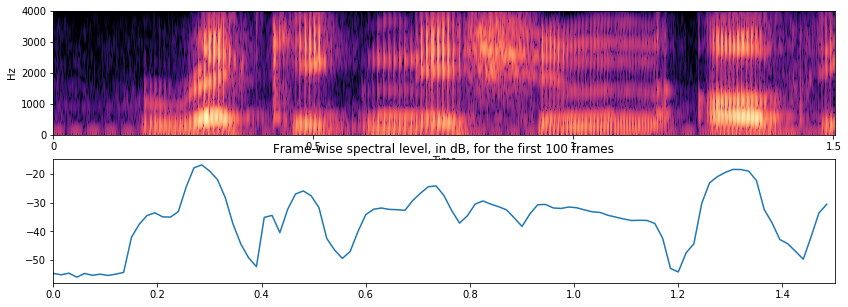

In [32]:
importlib.reload(submitted)
framelevel = submitted.framelevel(frames)
plt.figure(figsize=(14, 5))
plt.subplot(2,1,1)
librosa.display.specshow(Sdb, sr=samplerate, hop_length=int(0.002*samplerate), x_axis='time', y_axis='hz')
plt.subplot(2,1,2)
plt.plot(np.arange(100)*0.015, framelevel[:100])
plt.xlim([0,1.5])
plt.title('Frame-wise spectral level, in dB, for the first 100 frames')

-------------------------------------------------------------------------------
## Part 8: Linear interpolation of the pitch and level

OK, now we're finally done with the analysis!  We've converted the input speech into a  small set of parameters per frame:

*  The LPC coefficients, $a_1$ through $a_{10}$
*  The pitch period, $T_0$, in samples
* The spectral level, $L$, in decibels

Given those three parameters per frame, now we want to start the process of resynthesizing the speech signal.  

The first thing we need to do is to linearly interpolate the pitch period and the spectral level between frames.

In [20]:
importlib.reload(submitted)
help(submitted.interpolate)

Help on function interpolate in module submitted:

interpolate(framelevel, framepitch, hop_length)
    samplelevel, samplepitch = interpolate(framelevel, framepitch, hop_length)
    
    framelevel (num_frames) - levels[t] = power (energy/duration) of the t'th frame, in decibels
    framepitch (num_frames) - estimated pitch period, in samples, for each frame, or 0 if unvoiced
    hop_length  (scalar) - number of samples between start of each frame
    samplelevel ((num_frames-1)*hop_length+1) - linear interpolation of framelevel
    samplepitch ((num_frames-1)*hop_length+1) - modified linear interpolation of framepitch
    
    samplelevel is exactly as given by numpy.interp.
    samplepitch is modified so that samplepitch[n]=0 if the current frame or next frame are unvoiced.



If we plot the first 100 frames of ``framelevel`` and ``framepitch``, and compare it to the first ``100*hop_length`` samples of ``samplelevel`` and ``samplepitch``, they should look basically the same.

In [81]:
importlib.reload(submitted)
samplelevel, samplepitch = submitted.interpolate(framelevel, framepitch, hop_length)

[   0    1    2 ... 1185 1186 1187]
120


ValueError: x and y must have same first dimension, but have shapes (12000,) and (50,)

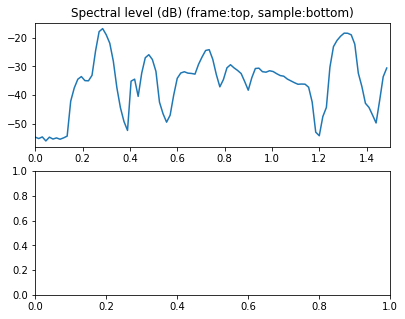

In [73]:
plt.figure(figsize=(14, 5))
plt.subplot(2,2,1)
plt.plot(np.arange(100)*0.015, framelevel[:100])
plt.xlim([0,1.5])
plt.title('Spectral level (dB) (frame:top, sample:bottom)')
plt.subplot(2,2,3)
plt.plot(np.arange(100*hop_length)/samplerate, samplelevel[:100*hop_length])
plt.xlim([0,1.5])
plt.subplot(2,2,2)
plt.plot(np.arange(100)*0.015, framepitch[:100])
plt.xlim([0,1.5])
plt.title('Pitch (samples) (frame:top, sample:bottom)')
plt.subplot(2,2,4)
plt.plot(np.arange(100*hop_length)/samplerate, samplepitch[:100*hop_length])
plt.xlim([0,1.5])

Notice, there is one difference between them: the frame pitch, on top, linearly interpolates between zero and large values (because pyplot linearly interpolates by default), whereas the sample pitch does not.

-------------------------------------------------------------
## Part 9: Create the LPC Excitation Signal

The LPC excitation signal is

$$e[n] = \left\{\begin{array}{ll} \mbox{Zero-mean Gaussian white noise}& \mbox{unvoiced}\\\mbox{Impulse train}&\mbox{voiced}\end{array}\right.$$

In [67]:
importlib.reload(submitted)
help(submitted.excitation)

Help on function excitation in module submitted:

excitation(samplelevel, samplepitch)
    phase, excitation = excitation(samplelevel, samplepitch)
    
    samplelevel ((num_frames-1)*hop_length+1) - effective level (in dB) of every output sample
    samplepitch ((num_frames-1)*hop_length+1) - effective pitch period for every output sample
    phase ((num_frames-1)*hop_length+1) - phase of the fundamental at every output sample,
      modulo 2pi, so that 0 <= phase[n] < 2*np.pi for every n.
    excitation ((num_frames-1)*hop_length+1) - LPC excitation signal
      if samplepitch[n]==0, then excitation[n] is zero-mean Gaussian
      if samplepitch[n]!=0, then excitation[n] is a delta function time-aligned to the phase
      In either case, excitation is scaled so its average power matches samplelevel[n].



There are two difficult points, here:

1. First, in order to keep track of when you should generate an impulse, you need to keep track of the phase of the fundamental frequency.  Remember that phase is just the integral of frequency, so it's given by

$$\phi[n] = \phi[n-1] + 2\pi F_0[n]$$

where $F_0[n]=1/T_0[n]$ is the pitch frequency in cycles/sample (or $F_0[n]=0$ if $T_0[n]=0$).  Every time $\phi[n]$ passes $2\pi$, we do two things: (1) Subtract $2\pi$, and (2) output an impulse in the excitation signal.

2. Second, this is an exercise for the reader: what scalar should you multiply times each sample of $e[n]$ so that the local average level is always ``samplelevel[n]``?  Notice that your answer is different for white noise  (where each sample is nonzero) versus an impulse train  (where very few samples are nonzero).

In [ ]:
importlib.reload(submitted)
phase, excitation = submitted.excitation(samplelevel, samplepitch)

Here's what the phase looks like.  Notice that during unvoiced regions, it remains constant.  During voiced regions, it rotates from $\phi=0$ to $\phi=2\pi$ once every pitch period.

NameError: name 'samplepitch' is not defined

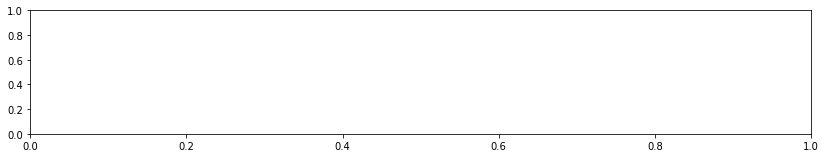

In [66]:
plt.figure(figsize=(14, 5))
plt.subplot(2,1,1)
plt.plot(np.arange(100*hop_length)/samplerate, samplepitch[:100*hop_length])
plt.xlim([0,1.5])
plt.title('Frequency (above) and Phase (below) of the fundamental')
plt.subplot(2,1,2)
plt.plot(np.arange(100*hop_length)/samplerate, phase[:100*hop_length])
plt.xlim([0,1.5])


And here's what the excitation signal looks like.  Notice that there's an impulse every time the phase returns  to zero.  During unvoiced frames, it is low-amplitude white noise.

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(2,1,1)
plt.plot(np.arange(100*hop_length)/samplerate, excitation[:100*hop_length])
plt.xlim([0,1.5])
plt.title('Excitation (above) and Phase (below)')
plt.subplot(2,1,2)
plt.plot(np.arange(100*hop_length)/samplerate, phase[:100*hop_length])
plt.xlim([0,1.5])


---------------------------------------------------------------------------------
## Part 10: LPC Synthesis


Now we have the excitation signal $e[n]$, and we have the LPC coefficients $a_k$, so we can use those things to resynthesize the speech signal!

In [ ]:
importlib.reload(submitted)
help(submitted.synthesize)

The synthesis formula is really just the standard direct-form IIR filter formula:

$$y[n] = e[n] + \sum_{k=1}^p a_k y[n-k]$$

In [ ]:
importlib.reload(submitted)
y = submitted.synthesize(excitation, a)
Y = librosa.stft(y[:int(1.5*samplerate)], hop_length=int(0.002*samplerate), win_length=int(0.005*samplerate))
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Ydb, sr=samplerate, hop_length=int(0.002*samplerate), x_axis='time', y_axis='hz')

In [ ]:
import IPython.display as ipd
ipd.Audio(y, rate=samplerate)

-----------------------------------------------------
## Grade your code on your own machine before submitting it!

If you reached this point in the notebook, then probably your code is working well, but before you run the autograder on  the  server, you should first run it on your own machine.

You can do that by going to a  terminal, and running the  following command line:

    python grade.py
    
If everything worked perfectly, you'll get a message that looks like this:

But  suppose that something didn't work well.  For example, suppose you run `python grade.py`, and you get the following:

This error message means that the function `test_synthesize`, in the file `tests/test_visible.py`, failed (all of the other tests succeeded -- only that one failed).

The error message specifies sample $y[8252]$ should have been $0.01161102437459162$, but instead, it was $0.02322204874918324$.  

How can you debug this?  

The autograder works as follows:

1. Load reference inputs and outputs of each function from the file `solutions.hdf5`
2. Put in the reference inputs, and get a hypothesis output.
3. Compare the reference and the hypothesis at a few sample points.  If they differ by more than one part in $10^7$, then call it an error.

You are strongly encouraged to load the file `solutions.hdf5`, and use it to debug your code.  Here's how to do it:

In [ ]:
import h5py
with h5py.File('solutions.hdf5','r') as f:
    print(list(f.keys()))

As  you can see, this file contains a lot of objects, created during a sample run of the solution code with random parameters.  Let's load the reference inputs and outputs of `synthesize`, compute a hypothesis output, and compare them in the neighborhood of sample $8252$:

In [ ]:
with h5py.File('solutions.hdf5','r')  as f:
    excitation_ref = np.array(f['excitation'][:])
    a_ref = np.array(f['a'])
    y_ref = np.array(f['y'][:])
    
importlib.reload(submitted)
y_hyp = submitted.synthesize(excitation_ref, a_ref)

plt.figure(figsize=(14, 5))
plt.plot(np.arange(8100,8400),y_ref[8100:8400],'b-',np.arange(8100,8400),y_hyp[8100:8400],'r--')

Right away, we notice that the expected solution (solid) is half the amplitude of the solution being generated by my file!  Upon inspection, I discover that I accidentally multiplied the excitation by $2$ at the input to the filter.  Fixing that line in `submitted.py` fixes all of the results.

When gradescope grades your code, it will run `grade.py`.  It will test your code using the solutions in `solutions.hdf5`, and using the test code `tests/test_visible.py`.  It will also test your code using some *hidden* tests.  The hidden tests are actually exactly the same as those in `tests/test_visible.py`, but with different input parameters.

---------------------
## Extra Credit

You can earn up to 10%  extra credit on this MP by finishing the file called `extra.py`, and submitting it to the autograder.

When you unpack the file ``mp1_extra.zip``, it will give you the following files:

* ``extra.py``.  This file has just one function, called `extra.better_vad`, which is the one  that you'll write.  Your  goal is to create a voice activity detector (VAD) that's better than the one implemented in the function ``submitted.framepitch``.
*  ``tests/test_extra.py``.  This file tests your ``better_vad``, to see what is its accuracy.  If your error rate is better than 15%, you get partial credit; if your error rate is better than 6%, you get full credit.
* ``extra_train.wav, extra_train_vuv.txt, extra_test.wav, extra_test_vuv.txt`` -- these are files that you  can  use  to train and test your VAD.  Note: you are also free to use any other data or methods that you find anywhere on the internet.   

In [ ]:
import extra
importlib.reload(extra)
help(extra.better_vad)

If you look in the file ``tests/test_extra.py``, you find the following grading scheme:

* Error rate below 15%: 1 point for the visible test file + 1  point for the hidden test file
* Error rate below 12%: 2 points for the visible test file + 2  points for the hidden test file
* Error rate below 9%: 3 points for the visible test file + 3  points for the hidden test file
* Error rate below 6%: 4 points for the visible test file + 4  points for the hidden test file

Hint: if you just implement the  same algorithm that  was used in `submitted.framepitch`, you won't get full credit, but you'll do pretty well.

Other features to think about include:

* Zero crossing rate: https://en.wikipedia.org/wiki/Zero-crossing_rate
* The G.729 standard uses line spectral frequencies, full-band energy, low-band energy (<1 kHz), and zero-crossing rate: https://en.wikipedia.org/wiki/Voice_activity_detection
* The Entropic Signal Processing VAD used just a three-dimensional feature vector: energy, ZCR, and normalized autocorrelation ($R[m]/R[0]$).

If you have a large external data source with labeled voiced/unvoiced frames, you could try training a neural net using the spectrogram.  I don't think that's necessary, though; with a three-dimensional feature vector, you should be able to tweak a VAD on `extra_train.wav` so that it gets low error on `extra_test.wav`.

When you think you have it working, you can test it by running:

    python grade.py
    
in your terminal.  Yes, indeed, this is the same code you ran for the regular MP!  The only difference is that, when you unzipped `mp1_extra.zip`, it gave you the test file `tests/text_extra.py`.  So now, when you run `grade.py`, it will grade both your regular MP, and the extra credit part.  

Having implemented only the default algorithm from ``submitted.frame_pitch``, here's what I get already:

... so in case  you didn't notice, that's already pretty good.

Congratulations!  That's the end of MP1.  Good luck!